# Stochastic Optimal Growth Model using ContinuousDPs

## Introduction

In this notebook  we learn how to use [ContinuousDPs.jl](https://github.com/QuantEcon/ContinuousDPs.jl) through the optimal growth model.


**Agenda**

- Describe the model that we consider in this notebook.

- Consider how to use ContinuousDPs.jl

- Check Results


## Model


In this section, we consider social plannner's problem in this notebook.


## Formulation
Social planner's problem is given as follows.


\begin{equation*}
\max_{\{c_t,k_{t+1}\}_{t=0}^{\infty}}\sum_{t=0}^{\infty} \beta^t u(c_t)
\end{equation*}
subject to 
\begin{equation*}
\forall t \ge 0,c_t + k_{t+1} \le z_tf(k_t) + (1-\delta)k_t
\end{equation*}

\begin{equation*}
\log z_{t+1} = \rho \log z_t + \epsilon, \epsilon \sim N(0, \sigma)
\end{equation*}

\begin{equation*}
\forall t \ge 0, c_t \ge 0, k_{t+1} \ge 0
\end{equation*}

\begin{equation*}
k_0 > 0, \,\,\text{given} 
\end{equation*}

- $u$: utility function
- $f$: productioon function
- $c$: consumption
- $k$: capital
- $z$: productivity
- $\beta \in (0,1)$: discount factor
- $\delta \in [0,1]$: depreciation rate
- $\rho \in (0,1)$: persitence of AR(1) process
- $\epsilon$: random component. assume i.i.d.
- $\sigma$: standard  deviation of random component

Suppose $u$ is continuous and strictly increasing utility function.

## Bellman equation

This sequential problem can be rewritten into a Bellman equation.

\begin{equation*}
V(k,z)= \max_{k'} \left\{ u( z f(k) + (1-\delta)k- k') + \beta E V(k',z') \right\}
\end{equation*}

subject to 

\begin{equation*}
\log z' = \rho \log z + \epsilon, \epsilon \sim N(0, \sigma)
\end{equation*}


## Parameterization

- Utility function $u(c) = \log(c)$
- Production function $f(k_t) = k_t^{\alpha}$

- $\beta = 0.95$
- $\delta = 1.0$
- $\rho = 0.9$
- $\alpha = 0.36$
- $\sigma = 0.1$

$\log z_{t+1} = \rho \log z_t + \epsilon$,
$\epsilon \sim N(0, \sigma)$


## True Solution

In the previous model, we have the following analytical solution which is derived by guess and verify.

\begin{equation*}
V(k_t,z_t) = F + G \ln z_t + H \ln k_t
\end{equation*}

- $F=\frac{1}{1-\beta}\left[\frac{\alpha \beta}{1-\alpha \beta}\ln \alpha \beta + \ln(1- \alpha \beta) \right]$
- $G = \frac{1-\alpha}{(1-\beta \rho)(1-\alpha \beta)}$
- $H = \frac{\alpha}{1-\alpha \beta}$


In [1]:
using LinearAlgebra
using QuantEcon
using BasisMatrices
using ContinuousDPs
using CompEcon
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
# parameters 
β= 0.95 # discount factor
δ= 1.0 # depreciation rate
ρ= 0.9 # persistence of AR(1)
α= 0.36 # capital share
σ = 0.01; # std for shock

In [3]:
# Coefficients for true solution
ab = α*β

F = (1.0/(1.0-β)) *((ab/(1.0-ab))*log(ab) + log(1.0-ab))
G = (1.0-α)/((1.0-(β*ρ))*(1.0 - ab))
H = α/(1.0-ab)

0.547112462006079

In [4]:
# Gaussian Hermite quadrature
n_shocks = 3
shocks, weights = qnwnorm(n_shocks, 0.0, σ^2)

([-0.0173205, 0.0, 0.0173205], [0.166667, 0.666667, 0.166667])

In [5]:
coef1 = [1,0]
coef2 = [0,1]

2-element Array{Int64,1}:
 0
 1

In [6]:
#x:control variable 
#s: state variables allows vector
f(s,x::Float64) = log(x) # utility function 

# state transition equation
g(s::Vector{Float64}, x::Float64, e::Float64) = coef1*(s[2]*s[1]^α+(1.0-δ)*s[1] - x) + 
                                                coef2*(s[2]^ρ*exp(e))
x_lb(s) = 1e-5 #lower bound
x_ub(s::Vector{Float64}) = s[2]*s[1]^α + (1.0-δ)*s[1]　# resource constraint

x_ub (generic function with 1 method)

In [7]:
# set nodes
#cheb
#n = [20, 30]
#s_min = [0.01 0.4]
#s_max = [8.5 1.7]
#basis = Basis(map(ChebParams, n, s_min, s_max)...)

# spline
k = [3, 3]
m = [15, 15]
breaks = m - (k.-1)
s_min = [0.01 0.5]
s_max = [10.0 1.5]
basis = Basis(map(SplineParams, breaks, s_min, s_max, k)...)

2 dimensional Basis on the hypercube formed by (0.01, 0.5) × (10.0, 1.5).
Basis families are Spline × Spline


In [8]:
cdp = ContinuousDP(f, g, β, shocks, weights, x_lb, x_ub, basis);

In [9]:
res = solve(cdp,VFI,v_init= ones(cdp.interp.length));

Compute iterate 50 with error 0.07318255549074593
Compute iterate 100 with error 0.005558340404807183
Compute iterate 150 with error 0.00042765775955544427
Compute iterate 200 with error 3.290610446171627e-5
Compute iterate 250 with error 2.5319594385564415e-6
Compute iterate 300 with error 1.9482159885342298e-7
Compute iterate 350 with error 1.4990579444429386e-8
Compute iterate 351 with error 1.424104922875813e-8
Converged in 351 steps


In [10]:
res2 = solve(cdp,VFI);

Compute iterate 50 with error 0.0691328199498713
Compute iterate 100 with error 0.005246733603723186
Compute iterate 150 with error 0.00040368118195388547
Compute iterate 200 with error 3.1061227275586134e-5
Compute iterate 250 with error 2.39000540602774e-6
Compute iterate 300 with error 1.838989547309211e-7
Compute iterate 349 with error 1.4894876443349858e-8
Converged in 349 steps


In [11]:
isapprox(res.V, res2.V)

true

In [12]:
res3 = solve(cdp,PFI,v_init= ones(cdp.interp.length));

Compute iterate 7 with error 7.815970093361102e-14
Converged in 7 steps


In [13]:
res4 = solve(cdp,PFI);

Compute iterate 7 with error 7.815970093361102e-14
Converged in 7 steps


In [14]:
isapprox(res3.V, res4.V)

true

In [15]:
s_min, s_max = cdp.interp.lb, cdp.interp.ub
grid_length = collect(cdp.interp.size) 
grids = [range(s_min[i], stop=s_max[i], length=grid_length[i]) for i in 1:2]
set_eval_nodes!(res, grids...)
V, X, resid = res.V, res.X, res.resid;

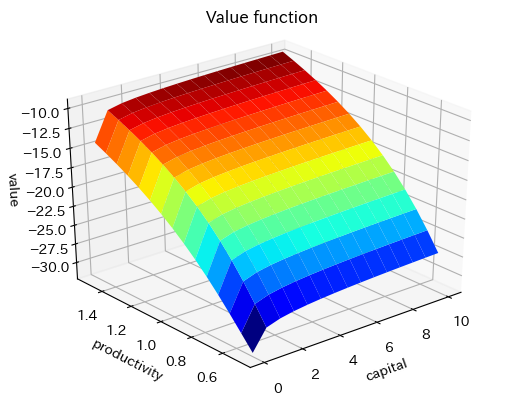

In [16]:
title = "Value function"
xlabel = "capital"
ylabel = "productivity"
zlabel = "value"
PyPlot.surf(grids..., permutedims(reshape(V, grid_length...)), cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

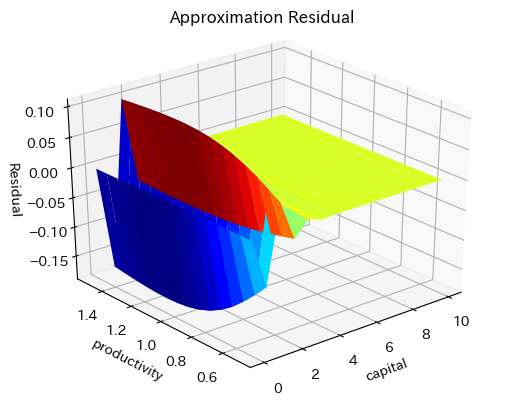

In [17]:
title = "Approximation Residual"
zlabel = "Residual"
PyPlot.surf(grids..., permutedims(reshape(resid, grid_length...)), cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

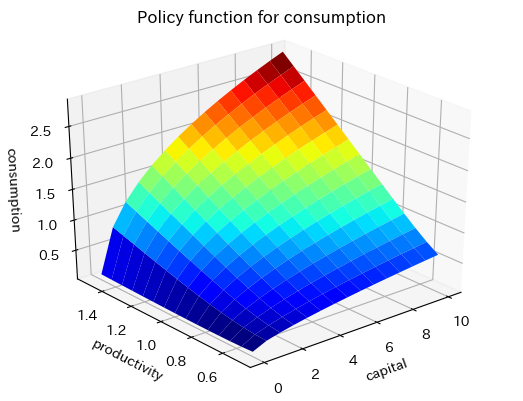

In [18]:
title = "Policy function for consumption"
xlabel = "capital"
ylabel = "productivity"
zlabel = "consumption"
PyPlot.surf(grids..., permutedims(reshape(X, grid_length...)), cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

In [19]:
kgrid =collect(grids[1])
zgrid = collect(grids[2])
mixgrid =gridmake(kgrid,zgrid)
# true solutoin
v_star(s::Array{Float64,2}) = F .+ G*log.(s[:,2]) .+ H*log.(s[:,1])
true_vfunc = v_star(mixgrid);
consumption(s::Array{Float64,2}) =  (1.0- ab)*s[:,2].*s[:,1].^α
true_cons = consumption(mixgrid);
saving(s::Array{Float64,2}) =  ab*s[:,2].*s[:,1].^α
true_saving = saving(mixgrid);

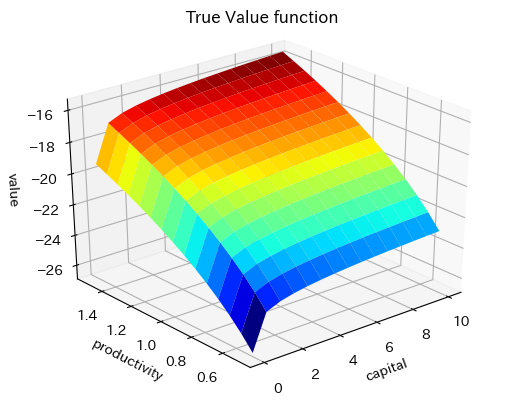

In [20]:
title = "True Value function"
xlabel = "capital"
ylabel = "productivity"
zlabel = "value"
PyPlot.surf(grids..., permutedims(reshape(true_vfunc, grid_length...)), cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

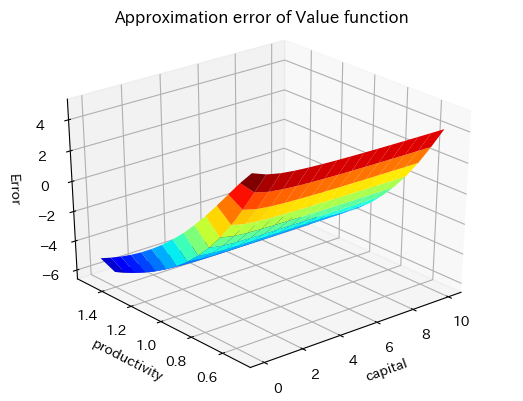

In [21]:
title = "Approximation error of Value function"
xlabel = "capital"
ylabel = "productivity"
zlabel = "Error"
PyPlot.surf(grids..., permutedims(reshape(true_vfunc-V, grid_length...)), cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

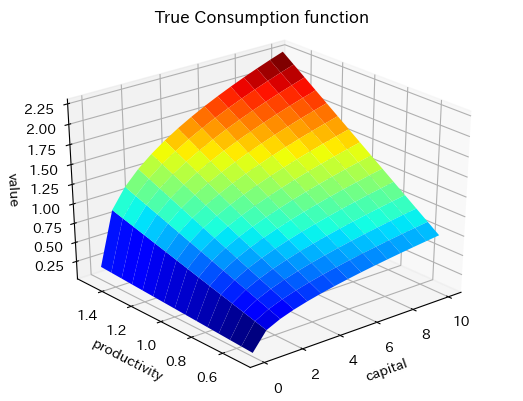

In [22]:
title = "True Consumption function"
xlabel = "capital"
ylabel = "productivity"
zlabel = "value"
PyPlot.surf(grids..., permutedims(reshape(true_cons, grid_length...)), cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

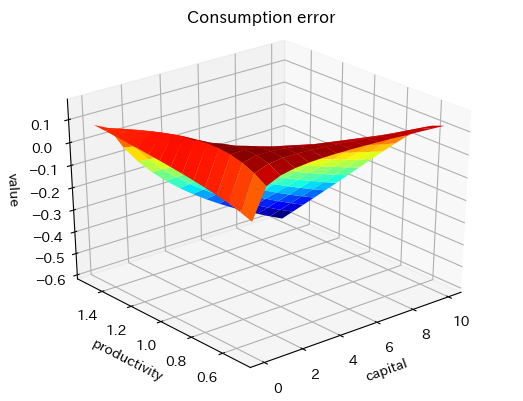

In [23]:
title = "Consumption error"
xlabel = "capital"
ylabel = "productivity"
zlabel = "value"
PyPlot.surf(grids..., permutedims(reshape(true_cons-X, grid_length...)), cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

In [24]:
ContinuousDPs.bellman_operator!(cdp, res.C, res.V, v_init= ones(cdp.interp.length))

225-element Array{Float64,1}:
 -1.4010084625646704 
  0.3841241042958918 
  0.02326044067407615
  0.5133348353359605 
  0.5786734813108331 
  0.6987463459952085 
  0.7723549041334379 
  0.8385440771568905 
  0.8931304251455102 
  0.9409447142595875 
  0.9830664415888071 
  1.020816750112253  
  1.0549845792891936 
  ⋮                  
  1.6119471240038312 
  1.6772857699786354 
  1.7973586346630666 
  1.870967192801308  
  1.9371563658247766 
  1.991742713813409  
  2.039557002927494  
  2.081678730256724  
  2.119429038780176  
  2.153596867957122  
  2.1744053753248624 
  2.1843957265339498 

In [25]:
ContinuousDPs.policy_iteration_operator!(cdp, res.C, res.X, v_init=ones(cdp.interp.length))

225-element Array{Float64,1}:
 -39.175894216779184
 -37.39076162107558 
 -37.75162527922137 
 -37.26155086988421 
 -37.19621221606311 
 -37.0761393441118  
 -37.00253078000308 
 -36.93634160164942 
 -36.88175524888257 
 -36.83394095539953 
 -36.791819224036445
 -36.75406891175428 
 -36.71990107905076 
   ⋮                
 -29.685038444861416
 -29.61969977534804 
 -29.499626888862757
 -29.42601831281302 
 -29.35982912379897 
 -29.305242761475654
 -29.257428459254623
 -29.21530671982389 
 -29.177556400024248
 -29.143388560267443
 -29.122580046243673
 -29.11258969179267 